**Isoforce**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def renderDF(path):
    DF = pd.read_csv(filename, delimiter="\t", header=0, skip_blank_lines=True)
    DF = pd.DataFrame(DF)

    for rnms in DF.columns:
        DF.rename(columns={rnms: rnms.split(" ")[0]}, inplace=True)

    DF = DF.loc[:, ~DF.columns.str.contains("^Unnamed")]
    DF = DF.dropna(how="all")
    return DF

In [2]:
filename = "data/data_set_1/Test FG_raw_data_12082024131438.txt"

DF = renderDF(filename)

In [3]:
DF

,Torque,Angle,Direction,Mode,Velocity,Record,
0,"-3,3","105,8",-1.0,CONCPM2,"15,0",1.0,"13,5"
1,"-3,3","105,8",-1.0,CONCPM2,"15,0",1.0,Protocol/
2,"-3,3","105,8",-1.0,CONCPM2,"15,0",1.0,Cushion/ 3
3,"-3,3","105,8",-1.0,CONCPM2,"15,0",1.0,Name/Test FG
4,"-3,2","105,8",-1.0,CONCPM2,"15,0",1.0,Filecode/Test FG12585612082024R0111
...,...,...,...,...,...,...,...
33789,"0,9","50,1",-1.0,CONCPM2,"15,0",1.0,
33790,"0,9","50,1",-1.0,CONCPM2,"15,0",1.0,
33791,"0,9","50,2",-1.0,CONCPM2,"15,0",1.0,
33792,"-0,2","50,2",-1.0,CONCPM2,"15,0",1.0,


In [4]:
def conv_array_float(arr):
    return np.array([float(x.replace(",", ".")) for x in arr])


class IsoforceIso:
    def __init__(self, DF):
        self.torque = conv_array_float(DF["Torque"])
        self.angle = conv_array_float(DF["Angle"])
        self.direction = DF["Direction"]
        self.mode = DF["Mode"]
        self.velocity = conv_array_float(DF["Velocity"])
        self.record = DF["Record"]

        self.detect_start_stop_idxs()
        self.export_torque_segments()

    def detect_start_stop_idxs(self):
        # use the velocity edges for start and stop times
        k = np.arange(len(self.velocity))
        dx_dk = np.gradient(self.velocity, k)
        self.start_idxs = np.where(dx_dk > np.mean(dx_dk))[0][1::2]
        self.stop_idxs = np.where(dx_dk < -np.mean(dx_dk))[0][::2]

    def export_torque_segments(self):
        idx = 0
        segment_dict = dict()
        for start, stop in zip(self.start_idxs, self.stop_idxs):
            segment_dict[f"seg_{idx}"] = self.torque[start:stop]
            idx += 1

        self.torque_segments = segment_dict

    def plot_torque(self):
        tks = np.round(np.linspace(np.min(self.torque), np.max(self.torque), 5))

        plt.figure(figsize=(12, 3))
        plt.plot(self.torque)
        plt.grid()
        # plt.yticks(ticks=tks, labels=tks)
        plt.xlabel("sample $k$")
        plt.ylabel("Torque (NM)")
        plt.show()

    def plot_angle(self):
        plt.figure(figsize=(12, 3))
        plt.plot(self.angle)
        plt.grid()
        plt.xlabel("sample $k$")
        plt.ylabel("Angle")
        plt.show()

    def plot_velocity(self):
        plt.figure(figsize=(12, 3))
        plt.plot(self.velocity)
        plt.scatter(
            self.start_idxs, self.velocity[self.start_idxs], c="C2", label="start idx"
        )
        plt.scatter(
            self.stop_idxs, self.velocity[self.stop_idxs], c="C3", label="stop idxs"
        )
        plt.grid()
        plt.xlabel("sample $k$")
        plt.ylabel("Velocity")
        plt.legend()
        plt.show()

    def plot_data(self, filename=None):
        plt.figure(figsize=(12, 3))
        plt.plot(self.torque, label="Torque")
        plt.plot(self.angle / 2, label="Angle / 2")
        plt.plot(self.velocity, label="Velocity")
        plt.scatter(
            self.start_idxs, self.velocity[self.start_idxs], c="C2", label="start idx"
        )
        plt.scatter(
            self.stop_idxs, self.velocity[self.stop_idxs], c="C3", label="stop idxs"
        )
        plt.legend()
        plt.grid()
        plt.xlabel("sample $k$")
        if filename != None:
            plt.tight_layout()
            plt.savefig(filename)
        plt.show()


iso_data = Isoforce(DF)

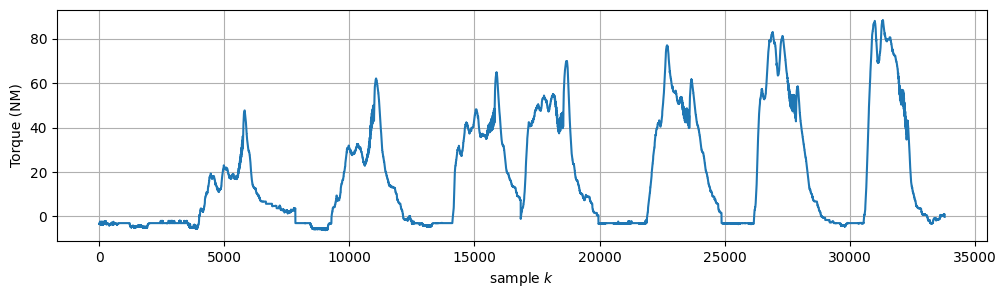

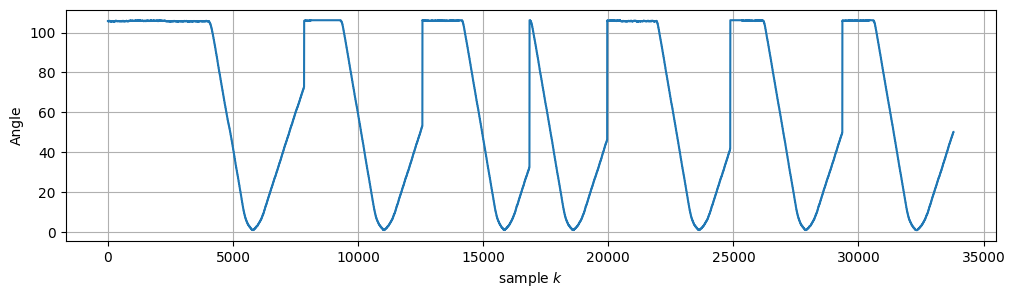

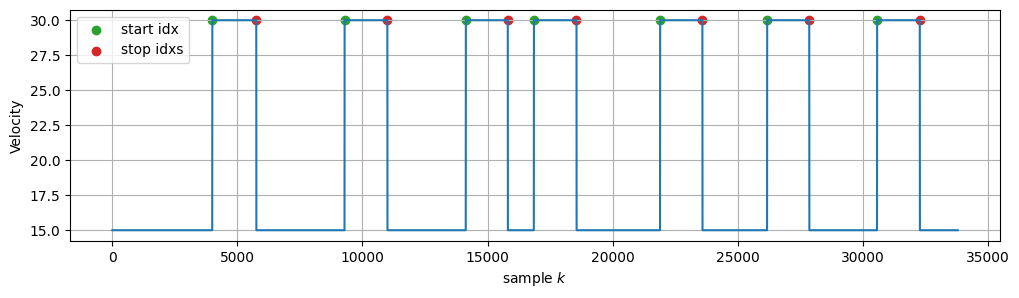

In [5]:
iso_data.plot_torque()
iso_data.plot_angle()
iso_data.plot_velocity()

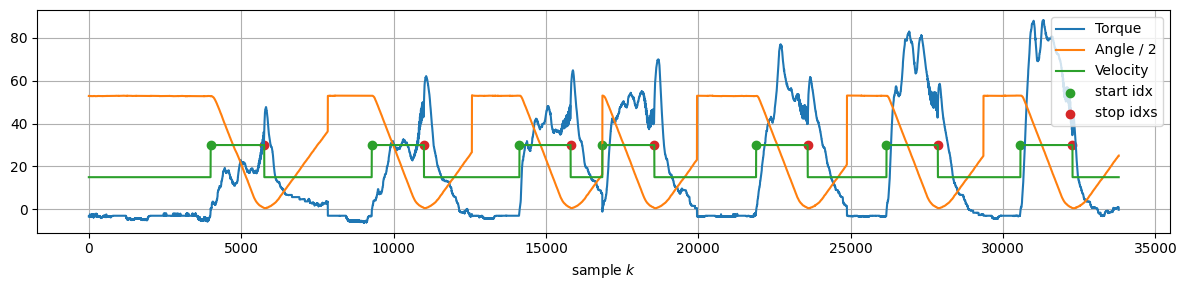

In [6]:
iso_data.plot_data("data_FG.png")

15.876350198976692
24.01728971962617
35.93537820131031
41.870909090909095
45.72813238770686
59.26913946587537
64.80292740046838


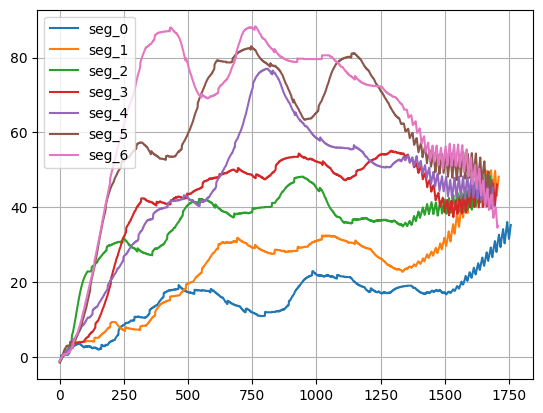

In [34]:
for key in iso_data.torque_segments.keys():
    plt.plot(iso_data.torque_segments[key], label=key)
    print(np.mean(iso_data.torque_segments[key]))
plt.legend()
plt.grid()
plt.show()

In [8]:
iso_data.sr = 400  # Hz
iso_data.n_samples = iso_data.torque.shape[0]

In [9]:
iso_data.n_samples

33794

In [59]:
iso_data.torque

array([-3.3, -3.3, -3.3, ...,  0.9, -0.2, -0.2])

**EIT data**

In [10]:
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

In [35]:
nm = list()
eit = list()
tsps = list()
for ele in np.sort(glob("data/data_set_1/EIT/sample*.npz")):
    tmp = np.load(ele, allow_pickle=True)
    eit.append(tmp["pot_mat"])
    nm.append(tmp["nm"])
    tsps.append(tmp["timestamp"])

nm = np.array(nm)
eit = np.array(eit)
tsps = np.array(tsps)

In [36]:
eit.shape

(14, 40, 16, 16)

In [37]:
[n for n in nm]

[np.int64(20),
 np.int64(20),
 np.int64(70),
 np.int64(70),
 np.int64(40),
 np.int64(40),
 np.int64(80),
 np.int64(80),
 np.int64(50),
 np.int64(50),
 np.int64(30),
 np.int64(30),
 np.int64(60),
 np.int64(60)]

In [ ]:
15.87
24.01
35.93
41.87
45.72
59.26
64.80

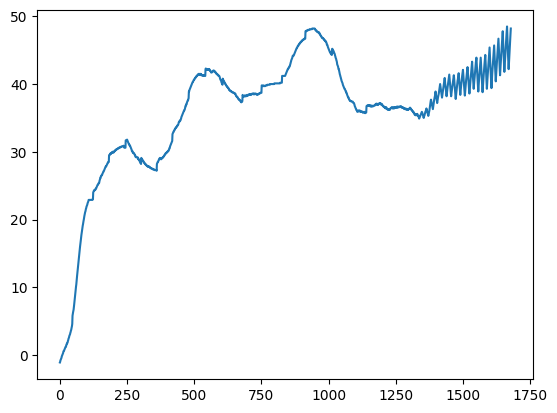

In [41]:
plt.plot(iso_data.torque_segments["seg_2"])

In [43]:
eit.shape

(14, 40, 16, 16)

In [45]:
for data in eit:
    print(data.shape)

(40, 16, 16)
(40, 16, 16)
(40, 16, 16)
(40, 16, 16)
(40, 16, 16)
(40, 16, 16)
(40, 16, 16)
(40, 16, 16)
(40, 16, 16)
(40, 16, 16)
(40, 16, 16)
(40, 16, 16)
(40, 16, 16)
(40, 16, 16)


In [44]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

20
70
40
80
50
30
60


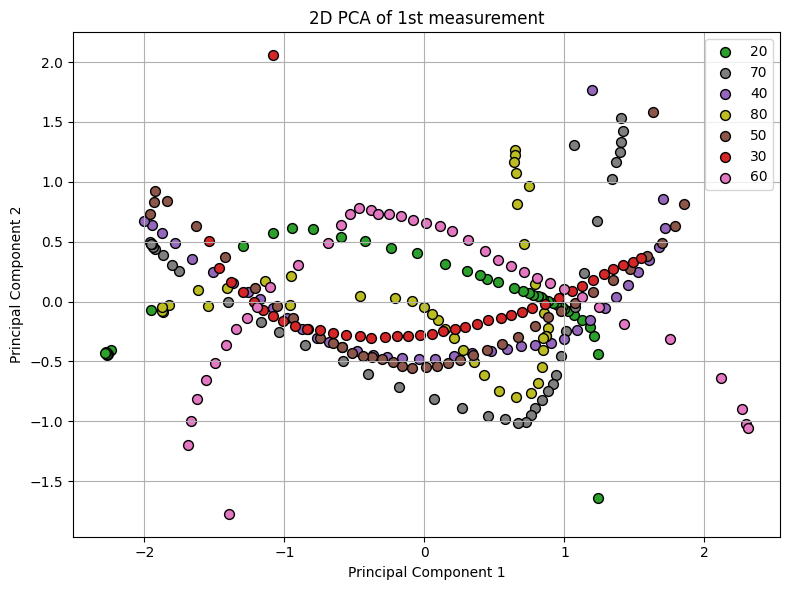

20
70
40
80
50
30
60


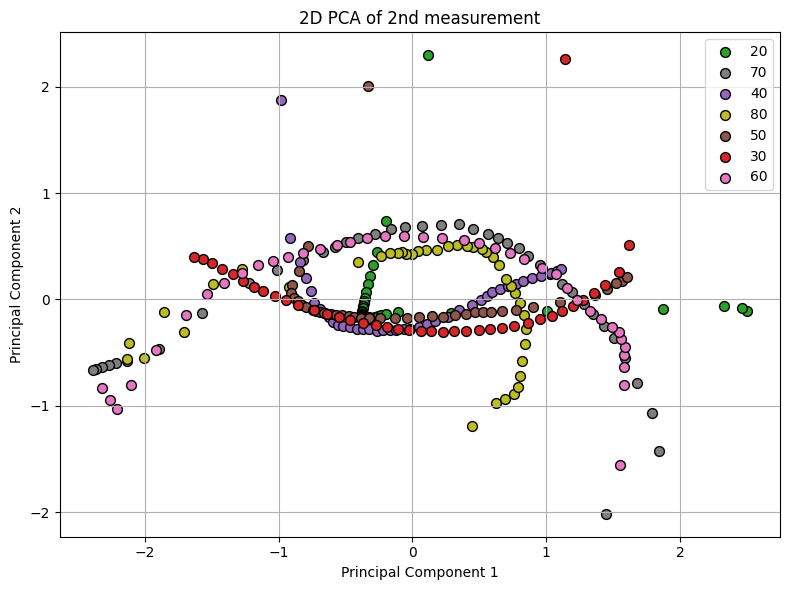

In [58]:
plt.figure(figsize=(8, 6))

for data, n in zip(eit[::2, ...], nm[::2, ...]):
    print(n)
    reshaped_data = np.abs(data.reshape(40, -1))

    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(reshaped_data)

    plt.scatter(
        data_2d[:, 0], data_2d[:, 1], c=f"C{n//10}", edgecolor="k", s=50, label=n
    )

plt.legend()
plt.title(f"2D PCA of 1st measurement")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("1st_measurement.png")
plt.show()

plt.figure(figsize=(8, 6))

for data, n in zip(eit[1::2, ...], nm[1::2, ...]):
    print(n)
    reshaped_data = np.abs(data.reshape(40, -1))

    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(reshaped_data)

    plt.scatter(
        data_2d[:, 0], data_2d[:, 1], c=f"C{n//10}", edgecolor="k", s=50, label=n
    )

plt.legend()
plt.title(f"2D PCA of 2nd measurement")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("2nd_measurement.png")
plt.show()